In [1]:
# Install necessary libraries
!pip install pandas gensim transformers torch scikit-learn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re
from gensim.models import KeyedVectors
import tensorflow as tf
from transformers import BertModel
from transformers import BertTokenizer
from transformers import TFBertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [3]:
# Load data
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

In [5]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [7]:
print('Train shape:',df_train.shape,'Test shape:',df_test.shape)

Train shape: (41157, 6) Test shape: (3798, 6)


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [9]:
df_train.Sentiment.value_counts()

,count
Sentiment,
Positive,11422
Negative,9917
Neutral,7713
Extremely Positive,6624
Extremely Negative,5481


Check for any null value

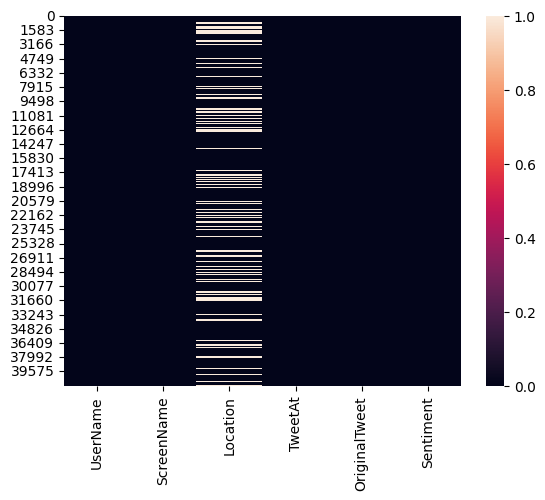

In [10]:
# check for null value in train_data
sns.heatmap(df_train.isnull());

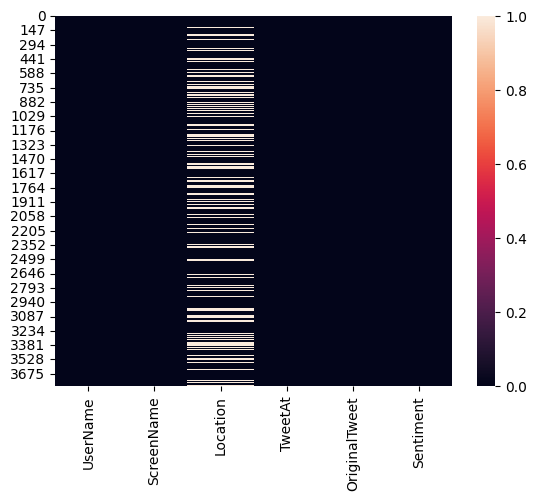

In [11]:
# check for null values in test data
sns.heatmap(df_test.isnull());

In [12]:
df_train.drop_duplicates(inplace= True)
df_test.drop_duplicates(inplace=True)

In [13]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [14]:
print(df_train.isnull().sum())
print("*"*50)
print(df_test.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
**************************************************
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [15]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})

<Axes: xlabel='count', ylabel='Sentiment'>

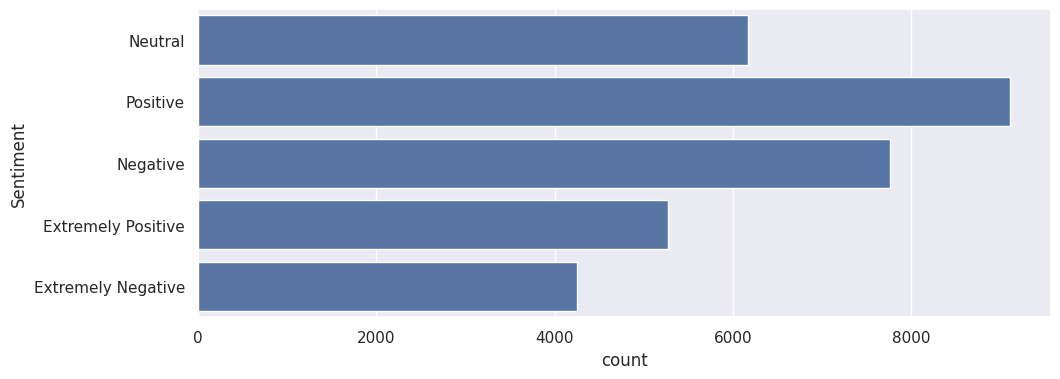

In [16]:
sns.countplot(df_train['Sentiment'])

In [17]:
df_train.shape, df_test.shape

((32567, 6), (2964, 6))

In [18]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

In [19]:
df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: change_sen(x))
df_test['Sentiment'] = df_test['Sentiment'].apply(lambda x: change_sen(x))

<Axes: xlabel='count', ylabel='Sentiment'>

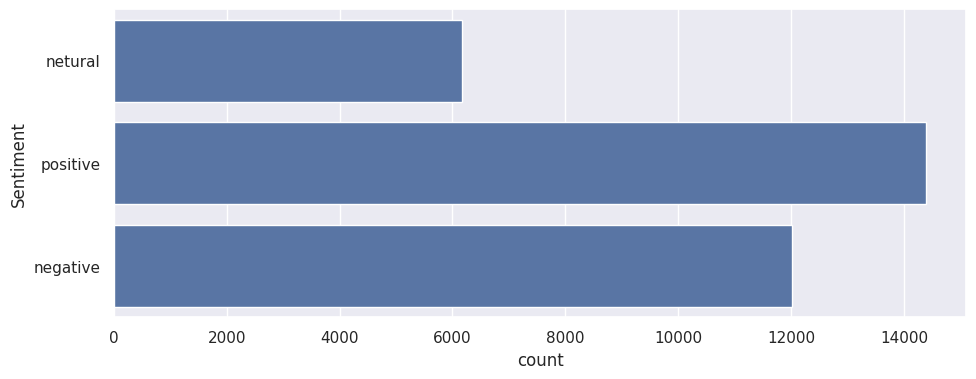

In [20]:
sns.countplot(df_train['Sentiment'])

<Axes: xlabel='count', ylabel='Sentiment'>

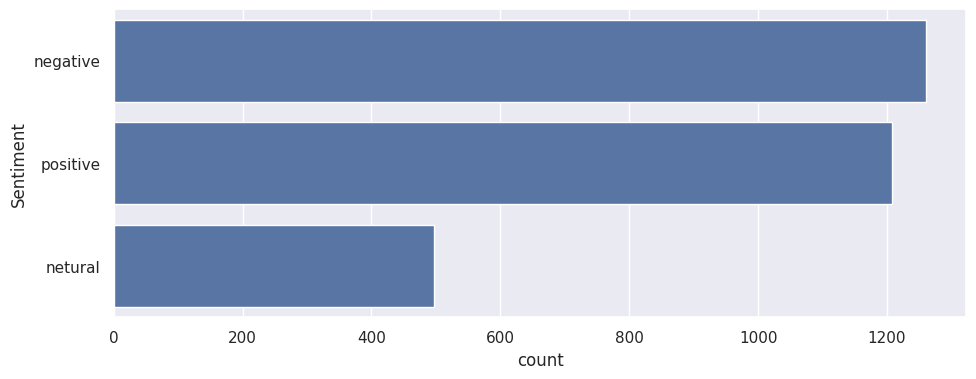

In [21]:
sns.countplot(df_test['Sentiment'])

In [22]:
# load stop words
nltk.download('stopwords')
stop_word = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)

    #     remove stop words
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])


    return text

In [24]:
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: clean(x))
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(lambda x: clean(x))

In [25]:
df_train = df_train.iloc[:,4:]
df_test = df_test.iloc[:,4:]

In [26]:
df_train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
5,As news regionÂs first confirmed COVID- case ...,positive
6,Cashier grocery store sharing insights To prov...,positive


In [27]:
l = {"netural":0, "positive":1,"negative":2}

In [28]:
df_train['Sentiment'] = df_train['Sentiment'].map(l)
df_test['Sentiment']  = df_test['Sentiment'].map(l)

In [29]:
df_train.head()

,OriginalTweet,Sentiment
0,,0
1,advice Talk neighbours family exchange phone n...,1
2,Coronavirus Australia: Woolworths give elderly...,1
5,As news regionÂs first confirmed COVID- case ...,1
6,Cashier grocery store sharing insights To prov...,1


# word2vec

In [30]:
!pip install gdown
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
From (redirected): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t&uuid=b2126a1d-6969-4884-a66d-83279f0ea543
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:57<00:00, 28.8MB/s]


In [31]:
# Load word2vec model
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [32]:
# Function to convert texts to vectors using word2vec
def get_average_vector(text, model):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return sum(word_vectors) / len(word_vectors)

df_train['Word2Vec_Vector'] = df_train['OriginalTweet'].apply(lambda x: get_average_vector(x, word2vec_model))
df_test['Word2Vec_Vector'] = df_test['OriginalTweet'].apply(lambda x: get_average_vector(x, word2vec_model))

# GloVe

In [33]:
# Download the file from the Internet
!wget https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the file
!unzip glove.6B.zip

--2024-08-29 12:24:52--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-29 12:24:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.15MB/s    in 2m 42s  

2024-08-29 12:27:36 (5.08 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [34]:
# Load GloVe model
glove_model = {}
with open("glove.6B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_model[word] = vector

In [35]:
# Function to convert texts to vectors using GloVe
def get_glove_vector(text, model):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return np.zeros(300)
    return sum(word_vectors) / len(word_vectors)

df_train['GloVe_Vector'] = df_train['OriginalTweet'].apply(lambda x: get_glove_vector(x, glove_model))
df_test['GloVe_Vector'] = df_test['OriginalTweet'].apply(lambda x: get_glove_vector(x, glove_model))

In [36]:
# Prepare data for training traditional models
X_train_word2vec = np.array(df_train['Word2Vec_Vector'].tolist())
X_test_word2vec = np.array(df_test['Word2Vec_Vector'].tolist())
X_train_glove = np.array(df_train['GloVe_Vector'].tolist())
X_test_glove = np.array(df_test['GloVe_Vector'].tolist())
y_train = df_train['Sentiment']
y_test = df_test['Sentiment']

In [37]:
# Train Logistic Regression model using word2vec
logistic_model_word2vec = LogisticRegression(max_iter=1000)
logistic_model_word2vec.fit(X_train_word2vec, y_train)

LogisticRegression(max_iter=1000)

In [38]:
# Train Logistic Regression model using GloVe
logistic_model_glove = LogisticRegression(max_iter=1000)
logistic_model_glove.fit(X_train_glove, y_train)

LogisticRegression(max_iter=1000)

# BERT

In [39]:
# Prepare data for BERT model
MAX_LEN = 64
tokenizer = BertTokenizer.from_pretrained('distilbert-base-cased')

def tokenize(tweets, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for tweet in tweets:
        encoding = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize(df_train['OriginalTweet'])
test_input_ids, test_attention_masks = tokenize(df_test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [40]:
# Load BERT model
bert_model = TFBertModel.from_pretrained('bert-base-cased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [41]:
# Create BERT model
def create_model(bert_model, max_len=MAX_LEN):
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    embeddings = bert_model([input_ids, attention_masks])[1]
    output = tf.keras.layers.Dense(3, activation='softmax')(embeddings)
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   72         'input_2[0][0]']             
                             hidden_state=(None, 64, 76                                           
                             8),                                                              

In [42]:
# Train BERT model
history = model.fit(
    [train_input_ids, train_attention_masks], y_train,
    validation_split=0.2,
    epochs=1,
    batch_size=64
)

408/408 [==============================] - 386s 829ms/step - loss: 0.7135 - accuracy: 0.6917 - val_loss: 0.5206 - val_accuracy: 0.8000


In [43]:
# Predict using word2vec, GloVe, and BERT model

y_pred_logistic_word2vec = logistic_model_word2vec.predict(X_test_word2vec)
y_pred_logistic_glove = logistic_model_glove.predict(X_test_glove)
res = model.predict([test_input_ids, test_attention_masks])
y_pred_bert = np.argmax(res, axis=1)

93/93 [==============================] - 19s 141ms/step


# Evaluate performance

In [44]:
# Word2Vec
print("Logistic Regression Model Performance (Word2Vec):")
print(classification_report(y_test, y_pred_logistic_word2vec,target_names=['Negative', 'Neutral', 'Positive']))

Logistic Regression Model Performance (Word2Vec):
              precision    recall  f1-score   support

    Negative       0.54      0.44      0.48       497
     Neutral       0.67      0.73      0.70      1207
    Positive       0.70      0.69      0.69      1260

    accuracy                           0.66      2964
   macro avg       0.64      0.62      0.63      2964
weighted avg       0.66      0.66      0.66      2964



In [45]:
# GloVe
print("Logistic Regression Model Performance (GloVe):")
print(classification_report(y_test, y_pred_logistic_glove,target_names=['Negative', 'Neutral', 'Positive']))

Logistic Regression Model Performance (GloVe):
              precision    recall  f1-score   support

    Negative       0.54      0.36      0.43       497
     Neutral       0.62      0.74      0.68      1207
    Positive       0.69      0.65      0.67      1260

    accuracy                           0.64      2964
   macro avg       0.62      0.58      0.59      2964
weighted avg       0.64      0.64      0.63      2964



In [46]:
# BERT
print("BERT Model Performance:")
print(classification_report(y_test, y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

BERT Model Performance:
              precision    recall  f1-score   support

    Negative       0.76      0.71      0.74       497
     Neutral       0.86      0.74      0.80      1207
    Positive       0.76      0.88      0.81      1260

    accuracy                           0.80      2964
   macro avg       0.79      0.78      0.78      2964
weighted avg       0.80      0.80      0.79      2964



# Display confusion matrix for each model

In [48]:
from sklearn.metrics import confusion_matrix
conf_matrix_word2vec = confusion_matrix(y_test, y_pred_logistic_word2vec)
conf_matrix_glove = confusion_matrix(y_test, y_pred_logistic_glove)
conf_matrix_bert = confusion_matrix(y_test, y_pred_bert)

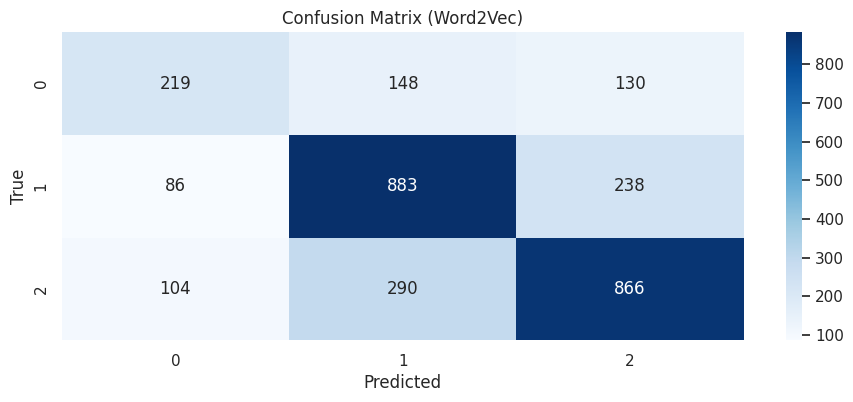

In [49]:
# Word2Vec
sns.heatmap(conf_matrix_word2vec, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix (Word2Vec)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

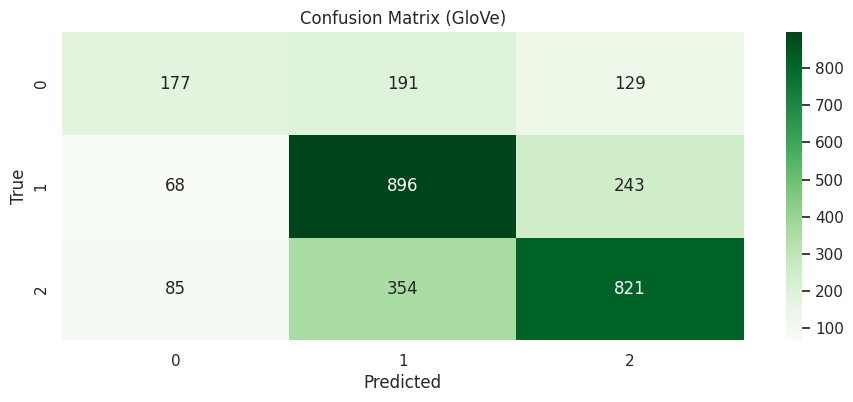

In [50]:
# GloVe
sns.heatmap(conf_matrix_glove, annot=True, fmt="d", cmap='Greens')
plt.title('Confusion Matrix (GloVe)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

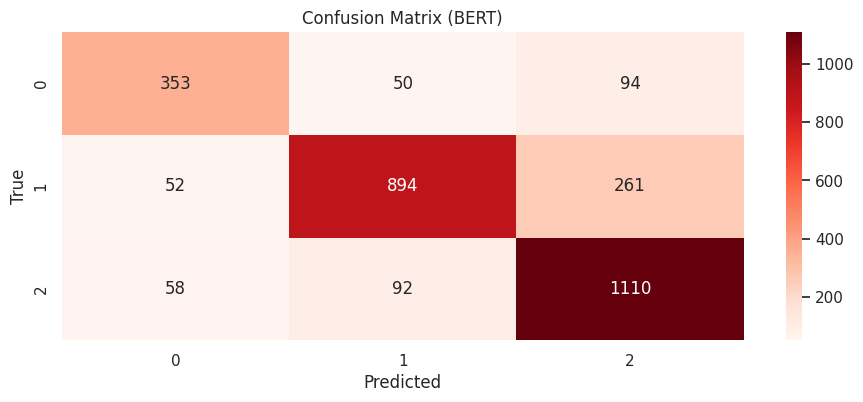

In [51]:
# BERT
sns.heatmap(conf_matrix_bert, annot=True, fmt="d", cmap='Reds')
plt.title('Confusion Matrix (BERT)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()